# Environment Setup

In [2]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import tensorflow as tf
import keras

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/spring/deep_learning/data"

Mounted at /content/drive


In [4]:
# allowing multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# stock under study
TICKER = "GOOG"
LIMIT = 200000

# type of option to study
OPTION = "call"

# Data Loading and Preprocessing

In [6]:
# loading the option pricing data
option_file_path = "{}/{}_{}_options.csv".format(
    data_dir, TICKER, LIMIT
)

option_df = pd.read_csv(option_file_path)
option_df.head()
option_df.tail()
option_df.shape

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
0,2019-02-09,GOOG,2019-02-22,930.0,Call,165.20,167.20,0.3589,0.9912,0.0003,-0.1298,0.0511,0.3523
1,2019-02-09,GOOG,2019-02-22,930.0,Put,0.15,0.40,0.3589,-0.0088,0.0003,-0.0648,0.0511,-0.0038
2,2019-02-09,GOOG,2019-02-22,985.0,Call,110.80,112.80,0.2968,0.9692,0.0011,-0.2245,0.1491,0.3639
3,2019-02-09,GOOG,2019-02-22,985.0,Put,0.70,0.95,0.2999,-0.0321,0.0011,-0.1630,0.1544,-0.0138
4,2019-02-09,GOOG,2019-02-22,1017.5,Call,79.50,81.40,0.2663,0.9270,0.0024,-0.3482,0.2972,0.3582


,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,theta,vega,rho
117101,2025-02-28,GOOG,2025-04-17,195.0,Put,23.25,23.55,0.2964,-0.8735,0.0133,-0.0307,0.1282,-0.1064
117102,2025-02-28,GOOG,2025-04-17,200.0,Call,0.76,0.77,0.2909,0.0939,0.0092,-0.0331,0.1046,0.0202
117103,2025-02-28,GOOG,2025-04-17,200.0,Put,27.95,28.30,0.3128,-0.9096,0.0107,-0.0245,0.1051,-0.0940
117104,2025-02-28,GOOG,2025-04-17,205.0,Call,0.53,0.56,0.3023,0.0683,0.0069,-0.0269,0.0823,0.0147
117105,2025-02-28,GOOG,2025-04-17,205.0,Put,32.25,34.45,0.3728,-0.8989,0.0092,-0.0333,0.1132,-0.1073


(117106, 13)

In [7]:
# loading the stock price data
stock_file_path = "{}/{}_stock.csv".format(
    data_dir, TICKER
)

stock_df = pd.read_csv(stock_file_path)
stock_df.head()

# drop first 2 rows
stock_df = stock_df.iloc[2:, :]
stock_df.reset_index(drop=True, inplace=True)
stock_df.rename(columns={"Price": "date"}, inplace=True)

stock_df.head()
stock_df.tail()
stock_df.shape

,Price,Close,High,Low,Open,Volume
0,Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
1,Date,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,53.05935287475586,53.15600571430183,52.07439323739906,52.22933502198347,24752000
3,2018-01-03,53.93022537231445,54.12004170065094,52.97017392960718,53.024977322253164,28604000
4,2018-01-04,54.12552261352539,54.482740536935125,54.00605213021857,54.20523802111377,20092000


,date,Close,High,Low,Open,Volume
0,2018-01-02,53.05935287475586,53.15600571430183,52.07439323739906,52.22933502198347,24752000
1,2018-01-03,53.93022537231445,54.12004170065094,52.97017392960718,53.024977322253164,28604000
2,2018-01-04,54.12552261352539,54.482740536935125,54.00605213021857,54.20523802111377,20092000
3,2018-01-05,54.914188385009766,55.01482851586672,54.404518360980745,54.504162619409385,25582000
4,2018-01-08,55.14884567260742,55.36456988594479,54.88379916670449,54.9141884799799,20952000


,date,Close,High,Low,Open,Volume
1756,2024-12-24,197.57000732421875,197.6699981689453,195.197998046875,196.1699981689453,6809800
1757,2024-12-26,197.10000610351562,198.16000366210938,195.8699951171875,196.74000549316406,7907900
1758,2024-12-27,194.0399932861328,196.8000030517578,191.9720001220703,196.47000122070312,14693000
1759,2024-12-30,192.69000244140625,193.77999877929688,190.36000061035156,190.86500549316406,12209500
1760,2024-12-31,190.44000244140625,193.25,189.5800018310547,192.44500732421875,14355200


(1761, 6)

In [8]:
# loading data for treasury yields
treasury_file_path = "{}/yield-curve-rates-1990-2024.csv".format(
    data_dir
)

treasury_df = pd.read_csv(treasury_file_path)
treasury_df.head()
treasury_df.tail()
treasury_df.shape

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,12/31/24,4.40,4.39,4.37,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
1,12/30/24,4.43,4.42,4.37,4.33,4.25,4.17,4.24,4.29,4.37,4.46,4.55,4.84,4.77
2,12/27/24,4.44,4.43,4.31,4.35,4.29,4.20,4.31,4.36,4.45,4.53,4.62,4.89,4.82
3,12/26/24,4.45,4.45,4.35,4.37,4.31,4.23,4.30,4.35,4.42,4.49,4.58,4.83,4.76
4,12/24/24,4.44,4.44,4.40,4.38,4.30,4.24,4.29,4.36,4.43,4.52,4.59,4.84,4.76


,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
8752,1/8/90,NaN,NaN,7.79,NaN,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
8753,1/5/90,NaN,NaN,7.79,NaN,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
8754,1/4/90,NaN,NaN,7.84,NaN,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
8755,1/3/90,NaN,NaN,7.89,NaN,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
8756,1/2/90,NaN,NaN,7.83,NaN,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00


(8757, 14)

In [9]:
# converting Close prices to numeric
stock_df["stock_price"] = pd.to_numeric(stock_df["Close"])

# calculation of historical volatilities
stock_df["return"] = stock_df["stock_price"] / stock_df["stock_price"].shift(1) - 1

# weekly - 5 trading days
stock_df["volatility_week"] = stock_df["return"].rolling(7).std()

# monthly - 21 trading days
stock_df["volatility_month"] = stock_df["return"].rolling(21).std()

# quarterly - 63 trading days
stock_df["volatility_quarter"] = stock_df["return"].rolling(63).std()

In [10]:
# merging the data
option_df["date"] = pd.to_datetime(option_df["date"])
stock_df["date"] = pd.to_datetime(stock_df["date"])

# convert monthly dates to 01 of the month for yields
treasury_df["date"] = pd.to_datetime(treasury_df["Date"])
treasury_df["date"] = pd.to_datetime(
    treasury_df["date"].dt.strftime("%Y-%m-01")
)

df = pd.merge(option_df, stock_df, on="date")

# take most row for the most recent date from treasury yield
treasury_df = treasury_df.sort_values(by="date", ascending=True)
df = pd.merge_asof(df, treasury_df, on="date", direction="backward")

df.head()
df.tail()
df.columns
df.shape

,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,2019-05-10,GOOG,2019-05-24,990.0,Call,171.00,180.30,0.3055,0.9971,0.0001,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
1,2019-05-10,GOOG,2019-05-24,990.0,Put,0.15,0.65,0.3036,-0.0028,0.0001,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
2,2019-05-10,GOOG,2019-05-24,1047.5,Call,114.10,123.40,0.3055,0.9651,0.0011,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
3,2019-05-10,GOOG,2019-05-24,1047.5,Put,0.65,1.25,0.3036,-0.0341,0.0011,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82
4,2019-05-10,GOOG,2019-05-24,1082.5,Call,80.80,88.50,0.2591,0.9305,0.0023,...,NaN,2.43,2.3,2.16,2.12,2.15,2.25,2.37,2.63,2.82


,date,act_symbol,expiration,strike,call_put,bid,ask,vol,delta,gamma,...,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
104405,2024-12-31,GOOG,2025-02-21,220.0,Put,29.75,30.45,0.3031,-0.9067,0.0107,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
104406,2024-12-31,GOOG,2025-02-21,225.0,Call,1.06,1.13,0.3225,0.1040,0.0077,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
104407,2024-12-31,GOOG,2025-02-21,225.0,Put,34.45,35.20,0.3069,-0.9447,0.0089,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
104408,2024-12-31,GOOG,2025-02-21,230.0,Call,0.80,0.84,0.3299,0.0801,0.0062,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78
104409,2024-12-31,GOOG,2025-02-21,230.0,Put,39.35,40.10,0.3210,-0.9645,0.0074,...,4.32,4.24,4.16,4.25,4.27,4.38,4.48,4.58,4.86,4.78


Index(['date', 'act_symbol', 'expiration', 'strike', 'call_put', 'bid', 'ask',
       'vol', 'delta', 'gamma', 'theta', 'vega', 'rho', 'Close', 'High', 'Low',
       'Open', 'Volume', 'stock_price', 'return', 'volatility_week',
       'volatility_month', 'volatility_quarter', 'Date', '1 Mo', '2 Mo',
       '3 Mo', '4 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr',
       '20 Yr', '30 Yr'],
      dtype='object')

(104410, 37)

In [11]:
# time to expiration in yrs
df["expiration"] = pd.to_datetime(df["expiration"])
df["time_to_maturity"] = pd.to_timedelta(df["expiration"] - df["date"]).dt.days / 365

# selecting risk-free rate
df["short_term_yield"] = df["1 Mo"]
df["long_term_yield"] = df["10 Yr"]

# forward-fill null values for risk-free rate
df["short_term_yield"] = df["short_term_yield"].fillna(method="ffill")
df["long_term_yield"] = df["long_term_yield"].fillna(method="ffill")

# option price to predict
df["option_price"] = (df["bid"] + df["ask"]) / 2

In [12]:
# select the option type
df = df[df["call_put"] == OPTION.title()]

# retain only the relevant columns
df = df[[
    "date", "option_price", "stock_price",
    "strike", "time_to_maturity",
    "volatility_week", "volatility_month", "volatility_quarter",
    "short_term_yield", "long_term_yield"
]]

# set date as index
df.set_index("date", inplace=True)

df.head()
df.shape
df.tail()

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
date,,,,,,,,,
2019-05-10,175.65,58.005085,990.0,0.038356,0.010326,0.019455,0.014109,2.4,2.37
2019-05-10,118.75,58.005085,1047.5,0.038356,0.010326,0.019455,0.014109,2.4,2.37
2019-05-10,84.65,58.005085,1082.5,0.038356,0.010326,0.019455,0.014109,2.4,2.37
2019-05-10,52.10,58.005085,1117.5,0.038356,0.010326,0.019455,0.014109,2.4,2.37
2019-05-10,33.90,58.005085,1140.0,0.038356,0.010326,0.019455,0.014109,2.4,2.37


(52205, 9)

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
date,,,,,,,,,
2024-12-31,2.830,190.440002,210.0,0.142466,0.013137,0.022279,0.018274,4.4,4.58
2024-12-31,2.020,190.440002,215.0,0.142466,0.013137,0.022279,0.018274,4.4,4.58
2024-12-31,1.470,190.440002,220.0,0.142466,0.013137,0.022279,0.018274,4.4,4.58
2024-12-31,1.095,190.440002,225.0,0.142466,0.013137,0.022279,0.018274,4.4,4.58
2024-12-31,0.820,190.440002,230.0,0.142466,0.013137,0.022279,0.018274,4.4,4.58


In [13]:
df.describe()
df.isnull().sum()

,option_price,stock_price,strike,time_to_maturity,volatility_week,volatility_month,volatility_quarter,short_term_yield,long_term_yield
count,52205.000000,52205.000000,52205.000000,52205.000000,52205.000000,52205.000000,52205.000000,52205.000000,52205.000000
mean,98.544506,120.427955,1165.349626,0.084135,0.018149,0.019111,0.019553,2.389603,2.655542
std,180.534623,32.679282,1107.531705,0.045052,0.009322,0.007377,0.005793,2.392389,1.412665
min,0.005000,52.641857,60.000000,0.027397,0.003397,0.006584,0.008819,0.010000,0.570000
25%,1.550000,94.809341,135.000000,0.043836,0.011861,0.014242,0.016074,0.080000,1.370000
50%,13.650000,122.149109,1080.000000,0.076712,0.016318,0.017750,0.018237,1.500000,2.880000
75%,87.250000,141.192673,2100.000000,0.126027,0.022301,0.022951,0.022928,5.250000,4.040000
max,1188.000000,198.160004,3900.000000,0.180822,0.075145,0.055992,0.038749,5.580000,4.830000


,0
option_price,0
stock_price,0
strike,0
time_to_maturity,0
volatility_week,0
volatility_month,0
volatility_quarter,0
short_term_yield,0
long_term_yield,0


Text(0.5, 0.98, 'Histograms for GOOG Call')

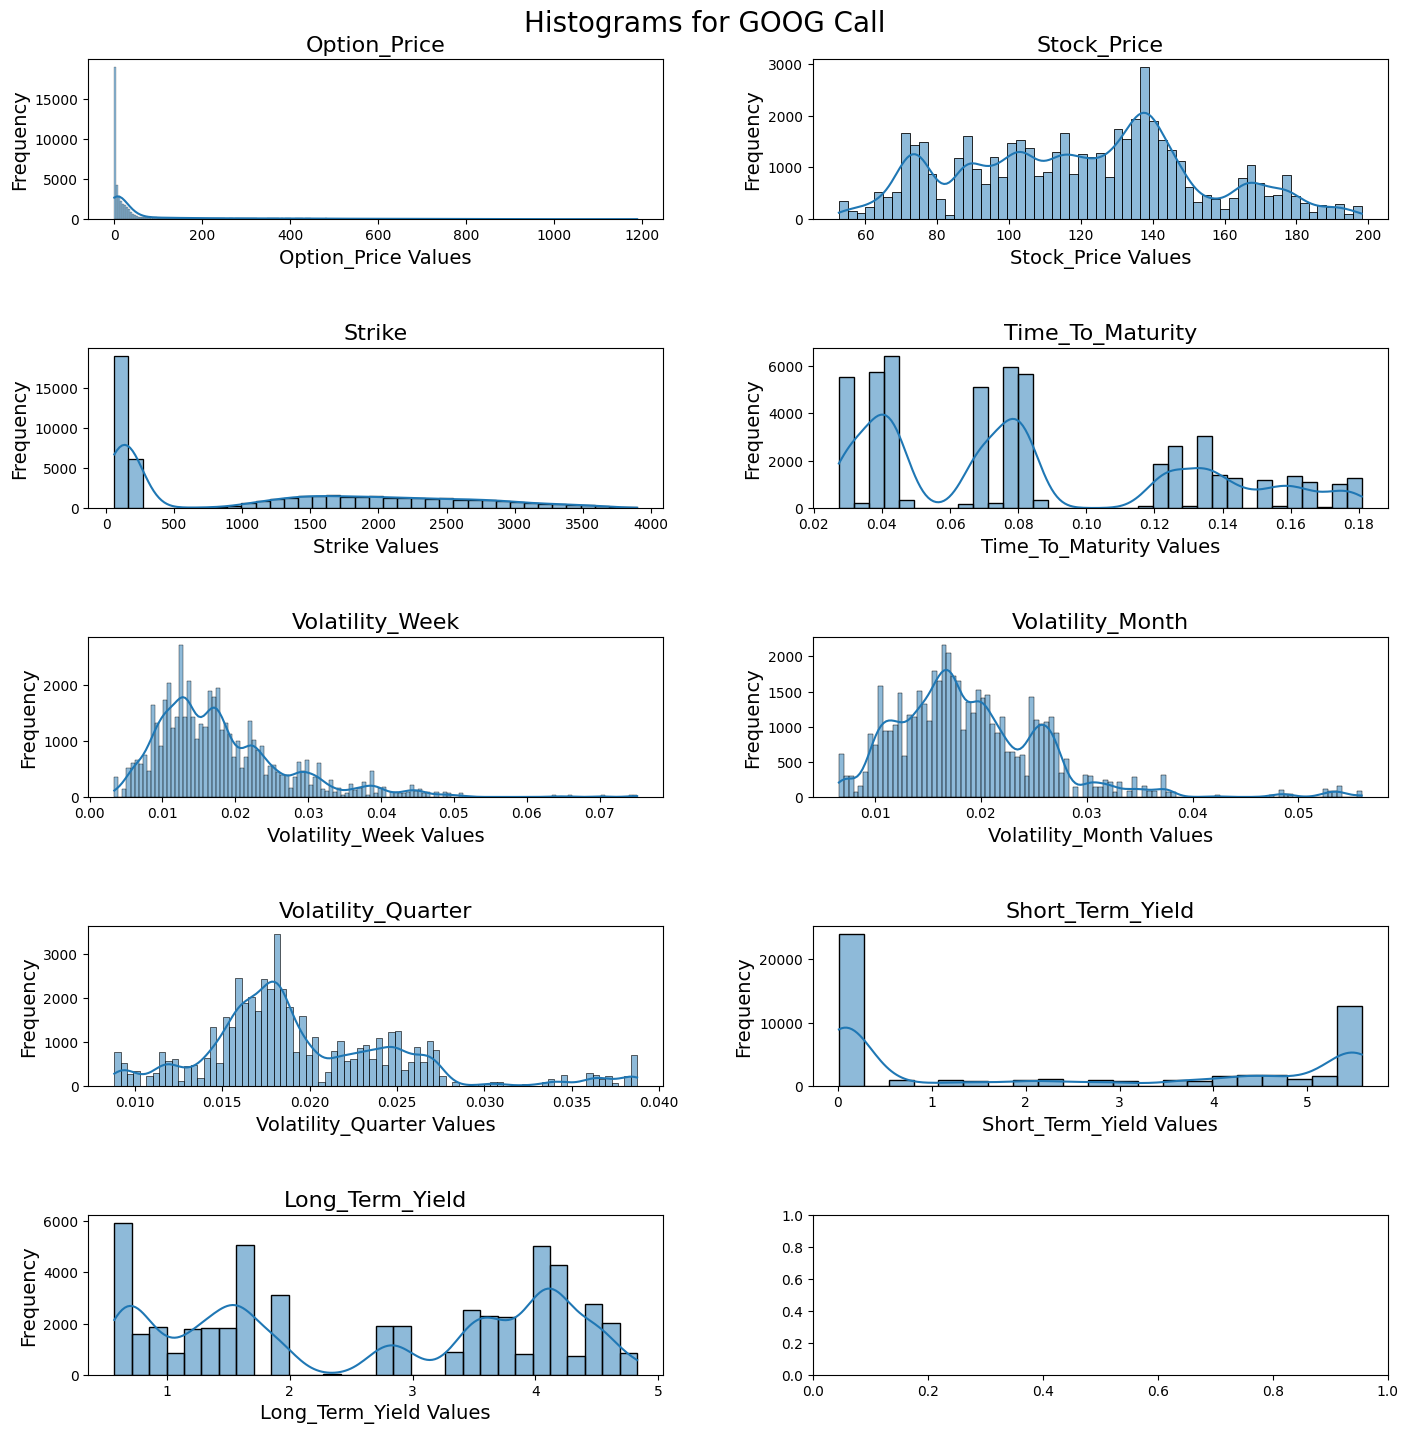

In [14]:
# plotting histograms of the columns
fig, ax = plt.subplots(
    nrows=df.shape[1] // 2 + df.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in df.columns:
    i, j = df.columns.get_loc(col) // 2, df.columns.get_loc(col) % 2
    _ = sns.histplot(
        df[col],
        ax=ax[i, j],
        kde=True
    )
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Frequency", fontsize=14)
    _ = ax[i, j].set_title("{}".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.suptitle("Histograms for {} {}".format(TICKER, OPTION.title()), fontsize=20)
plt.show()

Text(0.5, 0.98, 'Trace Plots for GOOG Call')

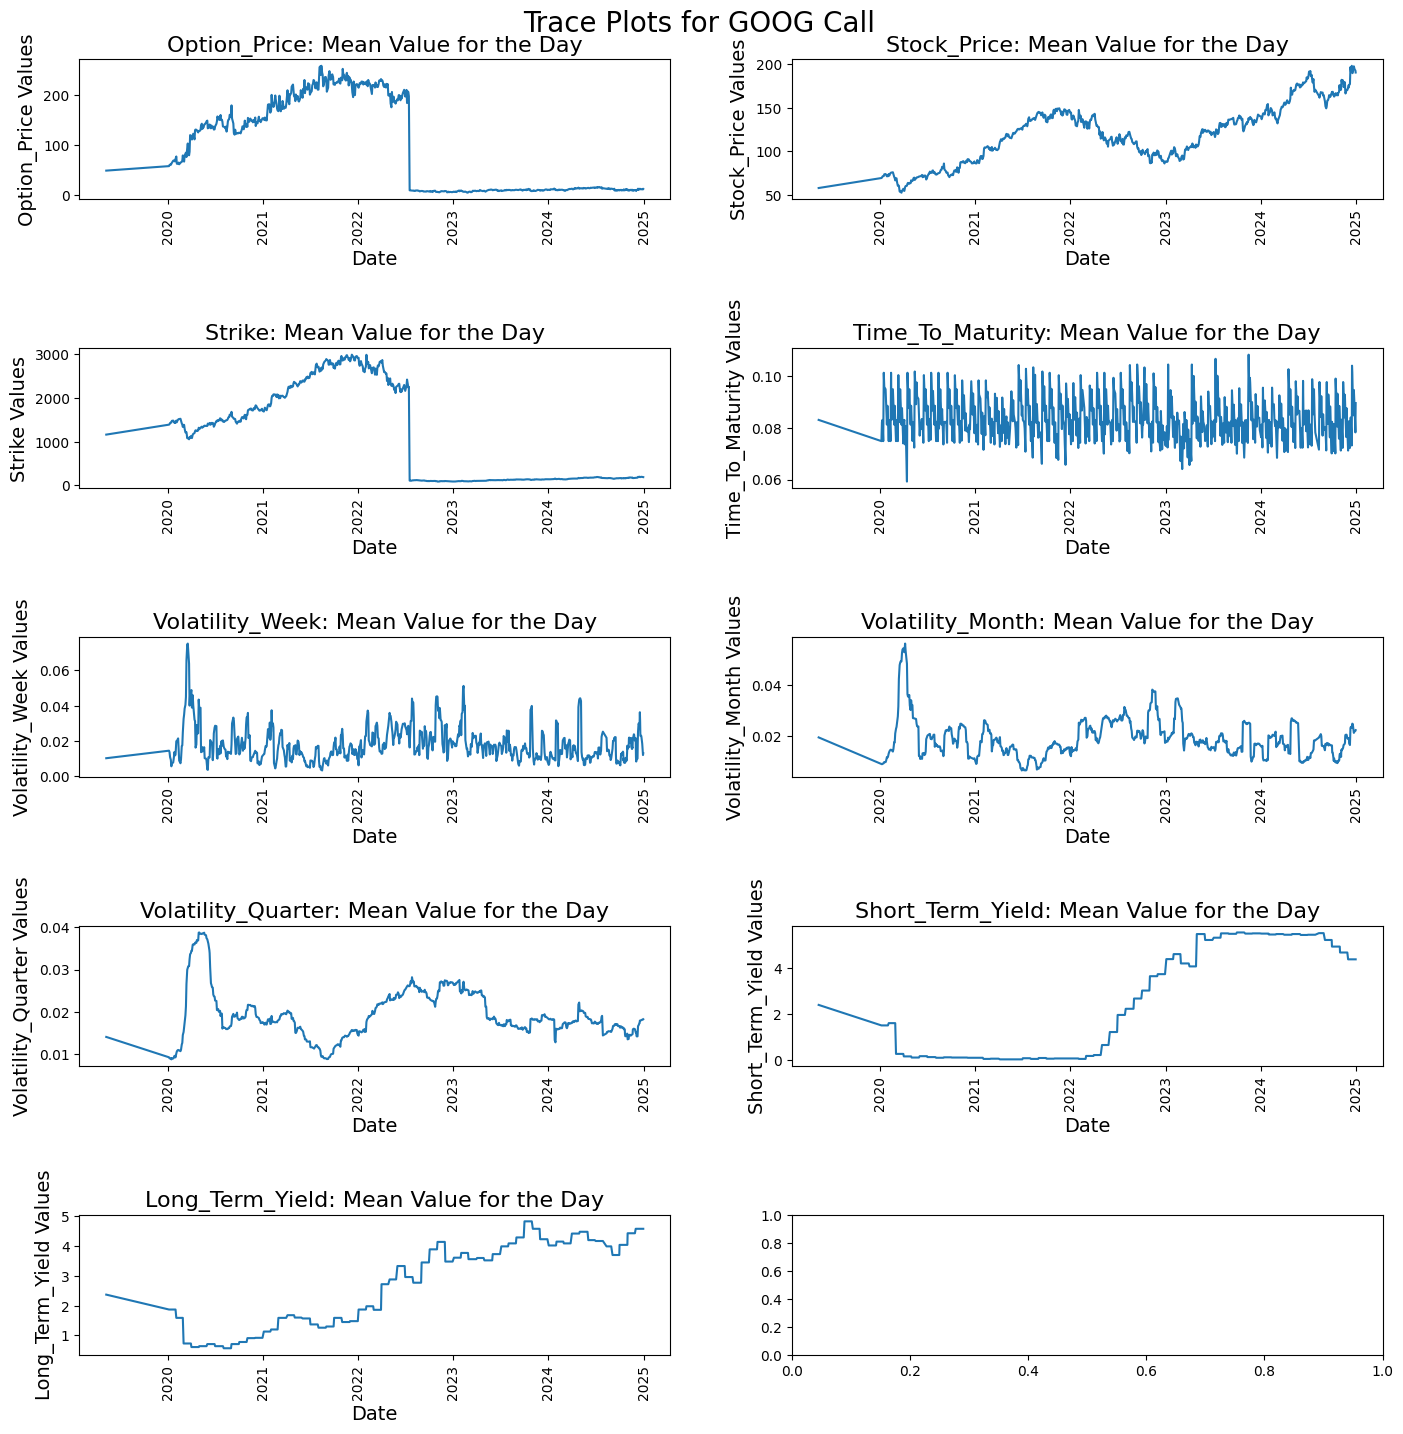

In [15]:
# plotting trace plots for the time series of columns
fig, ax = plt.subplots(
    nrows=df.shape[1] // 2 + df.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

# aggregate cols of df by index
df_agg = df.groupby(df.index).mean()

for col in df.columns:
    i, j = df.columns.get_loc(col) // 2, df.columns.get_loc(col) % 2
    ax[i, j].plot(df_agg.index, df_agg[col])
    _ = ax[i, j].set_xlabel("Date", fontsize=14)
    _ = ax[i, j].set_ylabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_title("{}: Mean Value for the Day".format(col.title()), fontsize=16)
    _ = ax[i, j].tick_params(axis='x', rotation=90)

plt.tight_layout(pad=4)
plt.suptitle("Trace Plots for {} {}".format(TICKER, OPTION.title()), fontsize=20)

# Fitting Models

In [16]:
# partitioning the data temporally
target_col = "option_price"
feature_cols = [
    col for col in df.columns if col != target_col
]

X = df[feature_cols]
y = df[target_col]

test_ratio = 0.2

train_end_date = X.shape[0] * (1 - test_ratio)
X_train = X.iloc[:int(train_end_date)]
X_test = X.iloc[int(train_end_date):]
y_train = y.iloc[:int(train_end_date)]
y_test = y.iloc[int(train_end_date):]

X_train.shape
X_test.shape
y_train.shape
y_test.shape

(41764, 8)

(10441, 8)

(41764,)

(10441,)

In [17]:
# for printing model performance
def print_model_performance(model, X_train, y_train, X_test, y_test, eps=1e-4):
    # MSE
    mse_train = mean_squared_error(y_train, model.predict(X_train))
    mse_test = mean_squared_error(y_test, model.predict(X_test))

    # RMSE
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print("---In Sample---")
    print("MSE: {:.2f}".format(mse_train))
    print("RMSE: {:.2f}".format(rmse_train))

    print("---Out of Sample---")
    print("MSE: {:.2f}".format(mse_test))
    print("RMSE: {:.2f}".format(rmse_test))

In [18]:
# BSM model functions
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * sp.stats.norm.cdf(d1) - K * np.exp(-r * T) * sp.stats.norm.cdf(d2)

def bs_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * sp.stats.norm.cdf(-d2) - S * sp.stats.norm.cdf(-d1)

def get_bs_calc(option_type):
    if option_type == "Call":
        return bs_call
    elif option_type == "Put":
        return bs_put
    else:
        raise ValueError("Invalid option type")

In [19]:
# using BSM model for predictions
bsm_model = get_bs_calc(OPTION.title())

S_train = X_train["stock_price"]
K_train = X_train["strike"]
T_train = X_train["time_to_maturity"]
r_train = X_train["short_term_yield"] / 100
sigma_train = X_train["volatility_month"]

S_test = X_test["stock_price"]
K_test = X_test["strike"]
T_test = X_test["time_to_maturity"]
r_test = X_test["short_term_yield"] / 100
sigma_test = X_test["volatility_month"]

y_train_bsm = bsm_model(S_train, K_train, T_train, r_train, sigma_train)
y_test_bsm = bsm_model(S_test, K_test, T_test, r_test, sigma_test)

print("---In Sample---")
print("MSE: {:.2f}".format(mean_squared_error(y_train, y_train_bsm)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_train, y_train_bsm))))

print("---Out of Sample---")
print("MSE: {:.2f}".format(mean_squared_error(y_test, y_test_bsm)))
print("RMSE: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_test_bsm))))

---In Sample---
MSE: 52716.73
RMSE: 229.60
---Out of Sample---
MSE: 4.19
RMSE: 2.05


In [20]:
# fitting a polynomial regression model
poly_reg = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    LinearRegression()
)

poly_reg.fit(X_train, y_train)

print_model_performance(poly_reg, X_train, y_train, X_test, y_test)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

---In Sample---
MSE: 7467.30
RMSE: 86.41
---Out of Sample---
MSE: 46994.96
RMSE: 216.78


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

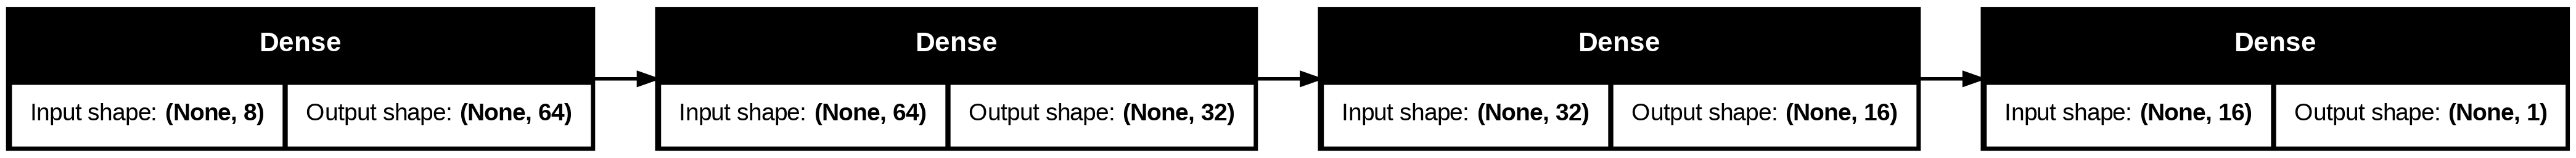

Epoch 1/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 24724.9590 - mse: 24724.7793 - val_loss: 26.8780 - val_mse: 26.7038
Epoch 2/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3619.1526 - mse: 3618.9773 - val_loss: 4.6363 - val_mse: 4.4547
Epoch 3/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1838.9625 - mse: 1838.7771 - val_loss: 2.4826 - val_mse: 2.2869
Epoch 4/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 734.3232 - mse: 734.1249 - val_loss: 5.5174 - val_mse: 5.3104
Epoch 5/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 375.1714 - mse: 374.9623 - val_loss: 6.2496 - val_mse: 6.0314
Epoch 6/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 276.5866 - mse: 276.3647 - val_loss: 15.4106 - val_mse: 15.1779
Epoch 7/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 269.1277 - mse: 268.8910 - val_loss: 2.1755 - val_mse: 1.9263
Epoch 8/50
653/653 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 232.7031 - mse: 232.4495 - val_loss: 1.6298 - val_mse: 1.3627
Epoch 9/50
6

In [21]:
# deep fully connected NN
deep_dense = keras.Sequential([
    keras.layers.Dense(
        64, activation="relu", input_shape=[X_train.shape[1]],
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(
        32, activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(
        16, activation="relu",
        kernel_regularizer=keras.regularizers.l2(0.001),
        bias_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer="he_normal"
    ),
    keras.layers.Dense(1)
])

deep_dense.summary()
keras.utils.plot_model(deep_dense, show_shapes=True, rankdir="LR")

deep_dense.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mse"]
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.1,
    restore_best_weights=True
)

deep_dense_history = deep_dense.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=50, batch_size=64, verbose=1,
    callbacks=[early_stop]
)

<Figure size 1000x600 with 0 Axes>

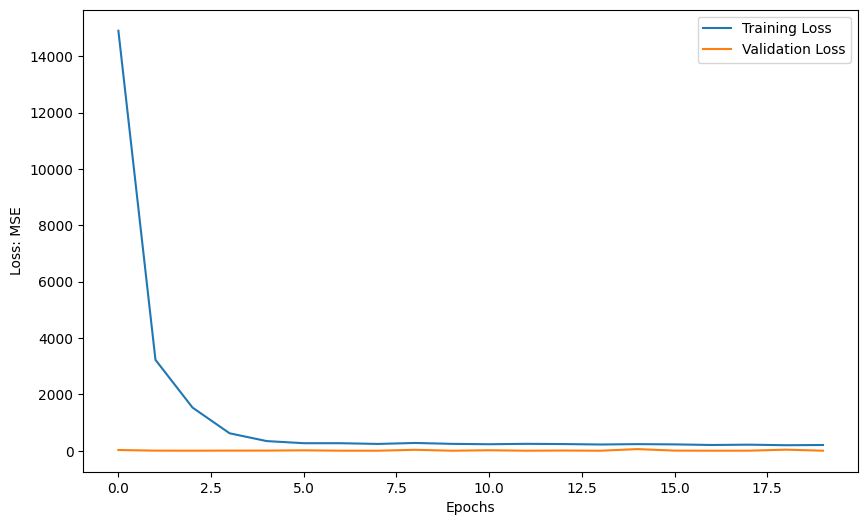

1306/1306 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
---In Sample---
MSE: 176.81
RMSE: 13.30
---Out of Sample---
MSE: 1.07
RMSE: 1.03


In [22]:
# plot loss plot for the model
plt.figure(figsize=(10, 6))
_ = plt.plot(deep_dense_history.history['loss'], label='Training Loss')
_ = plt.plot(deep_dense_history.history['val_loss'], label='Validation Loss')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss: MSE')
_ = plt.legend()
plt.show()

# model performance
print_model_performance(deep_dense, X_train, y_train, X_test, y_test)

In [25]:
# save the deep dense model
deep_dense.save("{}/deep_dense_model_{}_{}.keras".format(data_dir, TICKER, OPTION))

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │            288 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1, 32)          │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 8, 32)          │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 8, 32)          │         16,800 │ lambda_1[0][0],        │
│ (MultiHeadAttention)      │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8, 32)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 32)          │              0 │ lambda_1[0][0],        │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 8, 32)          │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8, 32)          │          1,056 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 8, 32)          │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 8, 32)          │          1,056 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 8, 32)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 8, 32)          │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 8, 32)          │         16,800 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 8, 32)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 8, 32)          │              0 │ layer_normalization_1… │
│                      

 Total params: 95,009 (371.13 KB)

 Trainable params: 95,009 (371.13 KB)

 Non-trainable params: 0 (0.00 B)

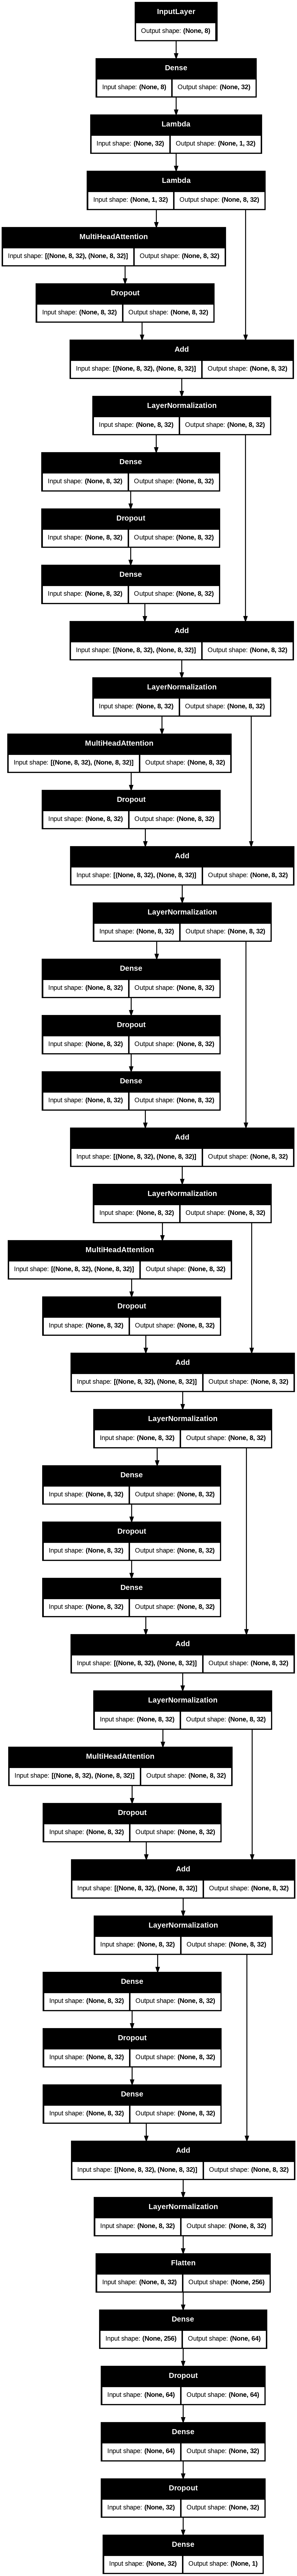

Epoch 1/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - loss: 33027.3164 - mse: 33023.1055 - val_loss: 223.0943 - val_mse: 218.4461
Epoch 2/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 6431.9834 - mse: 6427.2979 - val_loss: 51.0972 - val_mse: 46.2698
Epoch 3/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4159.7515 - mse: 4154.9160 - val_loss: 51.4855 - val_mse: 46.6496
Epoch 4/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 7108.4580 - mse: 7103.6235 - val_loss: 44.7541 - val_mse: 39.8927
Epoch 5/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3842.9614 - mse: 3838.0925 - val_loss: 46.0723 - val_mse: 41.1785
Epoch 6/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3386.3608 - mse: 3381.4470 - val_loss: 42.0352 - val_mse: 37.0646
Epoch 7/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 3277.5408 - mse: 3272.5659 - val_loss: 55.0505 - val_mse: 50.0384
Epoch 8/50
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 4968.8989 - mse: 4963.8960 - val_loss: 43.8372 -

In [26]:
# tab transformer
num_features = X_train.shape[1]
embedding_dim = 32
num_heads = 4
ff_dim = 32
num_transformer_blocks = 4
mlp_hidden_units = [64, 32]
dropout_rate = 0.1

inputs = keras.Input(shape=(num_features,))
embedded_features = keras.layers.Dense(
    embedding_dim, activation='relu',
    kernel_initializer=keras.initializers.GlorotUniform(),
    kernel_regularizer=keras.regularizers.l2(0.01)
)(inputs)
embedded_features = keras.layers.Lambda(
    lambda x: tf.expand_dims(x, axis=1)
)(embedded_features)
embedded_features = keras.layers.Lambda(
    lambda x: tf.tile(x, [1, num_features, 1])
)(embedded_features)

for _ in range(num_transformer_blocks):
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embedding_dim
    )(embedded_features, embedded_features)
    attention_output = keras.layers.Dropout(dropout_rate)(attention_output)

    x = keras.layers.Add()([embedded_features, attention_output])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    ff_output = keras.layers.Dense(
        ff_dim, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(x)
    ff_output = keras.layers.Dropout(dropout_rate)(ff_output)
    ff_output = keras.layers.Dense(
        embedding_dim, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(ff_output)

    embedded_features = keras.layers.Add()([x, ff_output])
    embedded_features = keras.layers.LayerNormalization(epsilon=1e-6)(embedded_features)

x = keras.layers.Flatten()(embedded_features)
for units in mlp_hidden_units:
    x = keras.layers.Dense(
        units, activation='relu',
        kernel_regularizer=keras.regularizers.l2(0.01),
        kernel_initializer=keras.initializers.GlorotUniform()
    )(x)
    x = keras.layers.Dropout(dropout_rate)(x)

outputs = keras.layers.Dense(1)(x)

tab_trans_model = keras.Model(inputs=inputs, outputs=outputs)
tab_trans_model.compile(optimizer='adam', loss='mse', metrics=["mse"])

tab_trans_model.summary()
keras.utils.plot_model(tab_trans_model, show_shapes=True)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.1,
    restore_best_weights=True
)
tab_trans_model_history = tab_trans_model.fit(
    X_train, y_train, validation_data=(X_test, y_test),
    epochs=50, batch_size=160, verbose=1,
    callbacks=[early_stop]
)

<Figure size 1000x600 with 0 Axes>

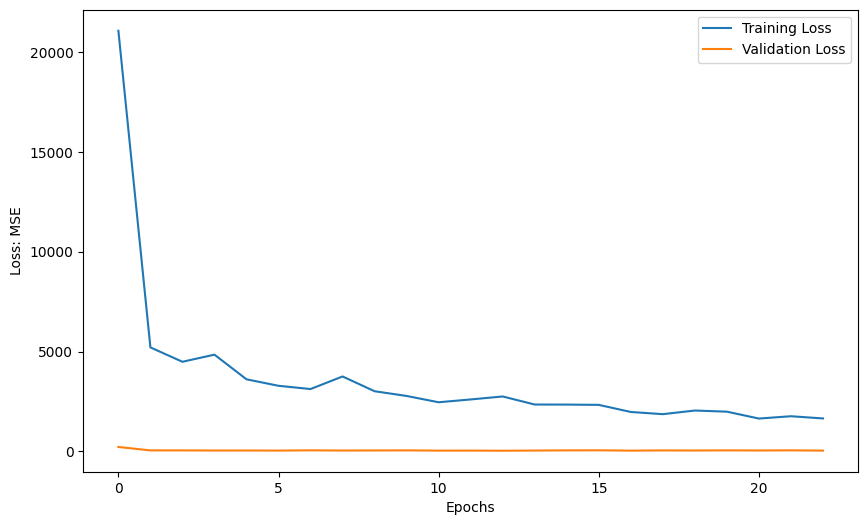

1306/1306 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
---In Sample---
MSE: 2859.14
RMSE: 53.47
---Out of Sample---
MSE: 29.79
RMSE: 5.46


In [27]:
# plot loss plot for the model
plt.figure(figsize=(10, 6))
_ = plt.plot(tab_trans_model_history.history['loss'], label='Training Loss')
_ = plt.plot(tab_trans_model_history.history['val_loss'], label='Validation Loss')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss: MSE')
_ = plt.legend()
plt.show()

# model performance
print_model_performance(tab_trans_model, X_train, y_train, X_test, y_test)

# Error Analysis

In [28]:
# retrieve the best model: deep dense
model = keras.models.load_model("{}/deep_dense_model_{}_{}.keras".format(data_dir, TICKER, OPTION))

In [29]:
# get the residuals for the best model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# reshape into 1D arrays
y_train_pred = y_train_pred.reshape(-1)
y_test_pred = y_test_pred.reshape(-1)

y_train.shape
y_test.shape
y_train_pred.shape
y_test_pred.shape

res_test = y_test - y_test_pred
res_train = y_train - y_train_pred

1306/1306 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


(41764,)

(10441,)

(41764,)

(10441,)

Text(0.5, 0.98, 'Residuals against Features: Training')

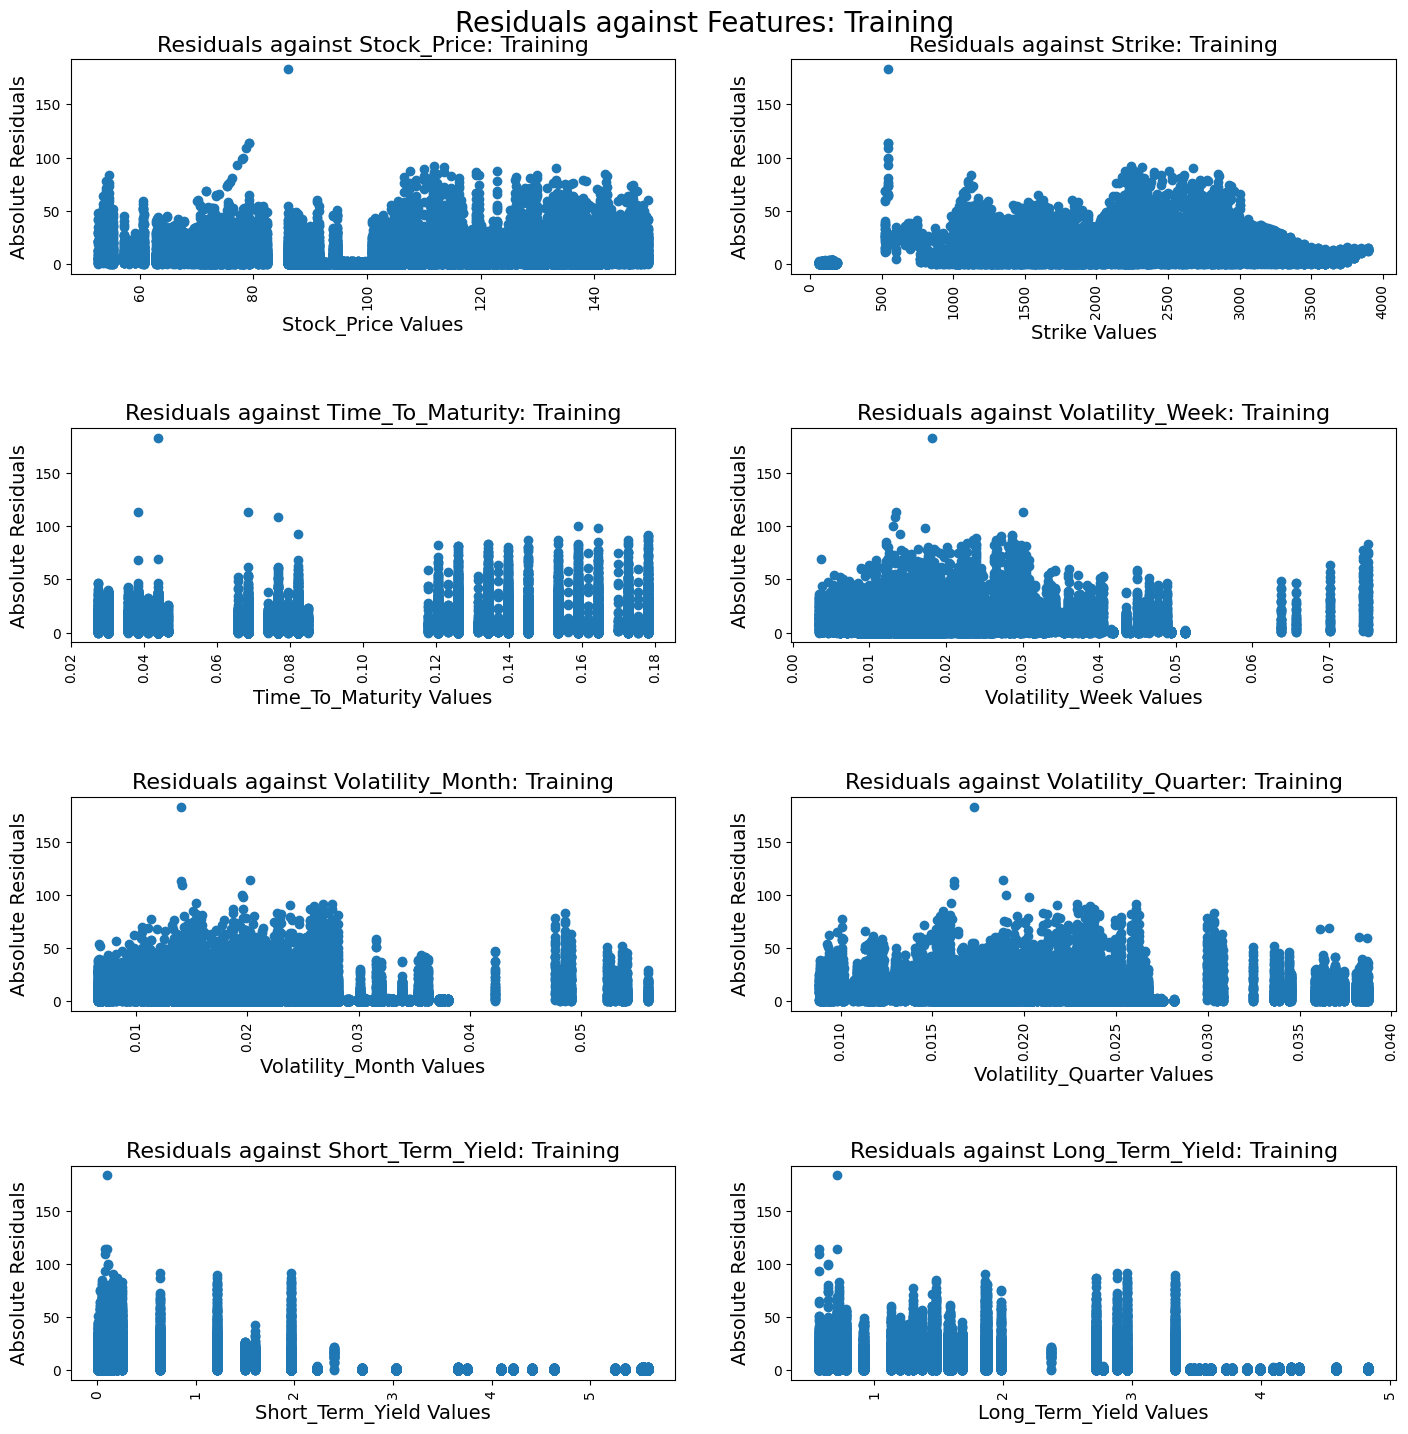

Text(0.5, 0.98, 'Residuals against Features: Testing')

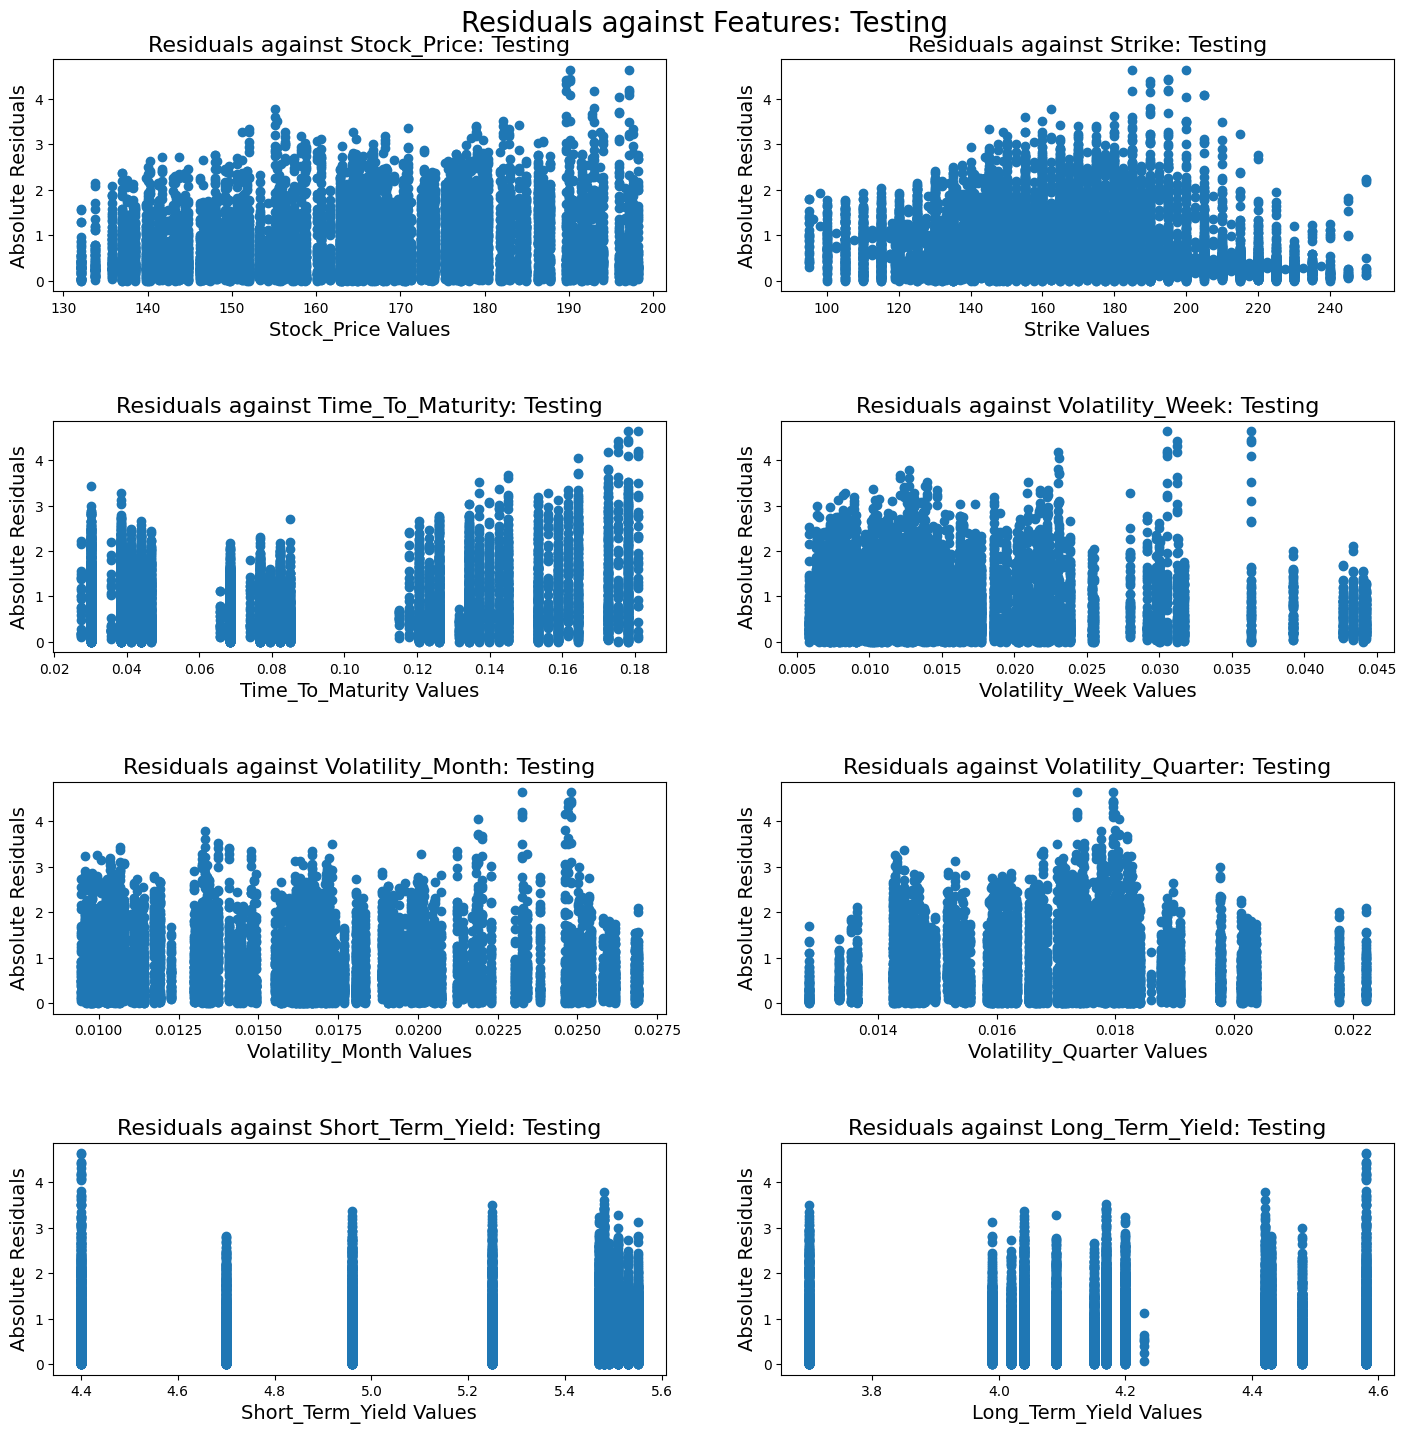

In [30]:
# plotting absolute residuals against the different features
fig, ax = plt.subplots(
    nrows=X_train.shape[1] // 2 + X_train.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in X_train.columns:
    i, j = X_train.columns.get_loc(col) // 2, X_train.columns.get_loc(col) % 2
    _ = ax[i, j].scatter(X_train[col], np.abs(res_train))
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Residuals against {}: Training".format(col.title()), fontsize=16)
    _ = ax[i, j].tick_params(axis='x', rotation=90)

plt.tight_layout(pad=4)
plt.suptitle("Residuals against Features: Training", fontsize=20)
plt.show()

fig, ax = plt.subplots(
    nrows=X_test.shape[1] // 2 + X_test.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)
for col in X_test.columns:
    i, j = X_test.columns.get_loc(col) // 2, X_test.columns.get_loc(col) % 2
    _ = ax[i, j].scatter(X_test[col], np.abs(res_test))
    _ = ax[i, j].set_xlabel("{} Values".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Residuals against {}: Testing".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.suptitle("Residuals against Features: Testing", fontsize=20)
plt.show()

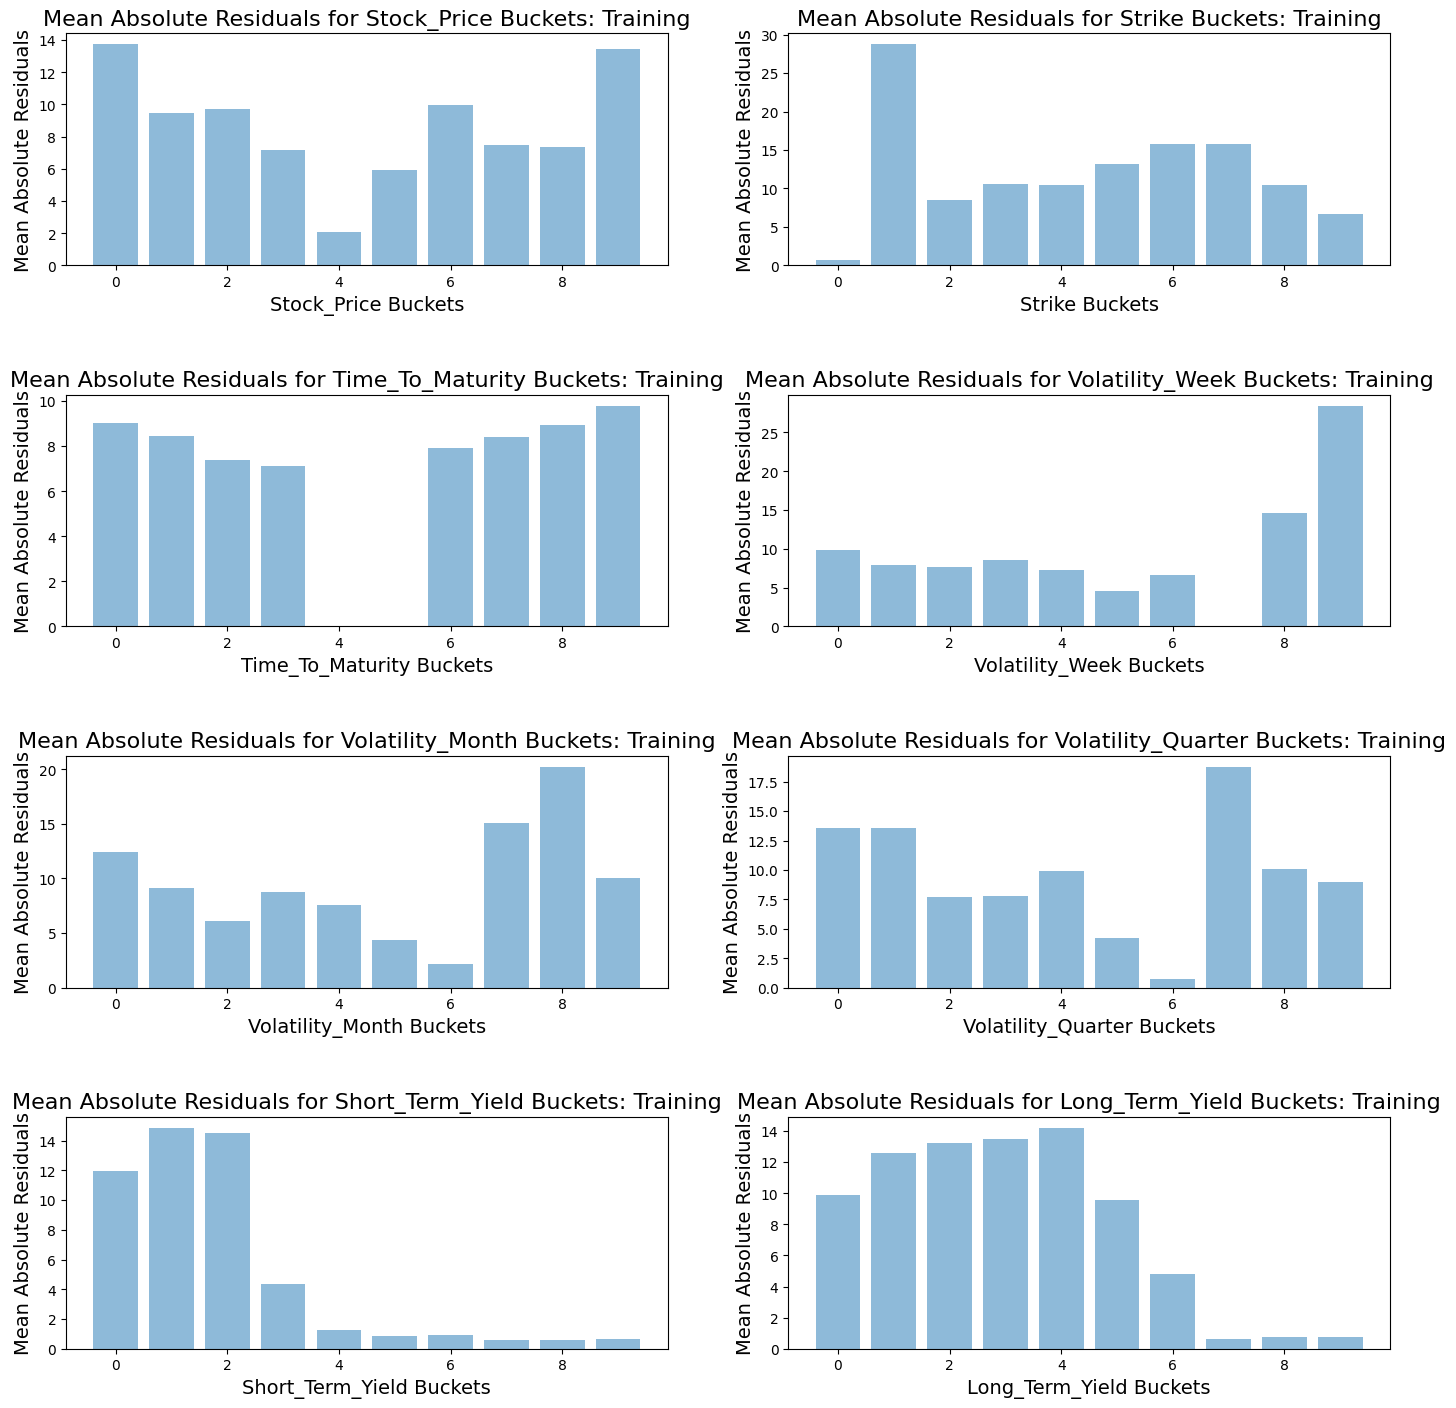

In [31]:
# create 10 buckets of values for each col
X_train_analysis = X_train.copy()
X_test_analysis = X_test.copy()

for col in X_train.columns:
    X_train_analysis[col + "_bucketed"] = pd.cut(X_train[col], 10, labels=False)
    X_test_analysis[col + "_bucketed"] = pd.cut(X_test[col], 10, labels=False)

# bar graph of mean values of absolute residuals for each bucket
fig, ax = plt.subplots(
    nrows=X_train.shape[1] // 2 + X_train.shape[1] % 2,
    ncols=2,
    figsize=(15, 15)
)

for col in X_train.columns:
    i, j = X_train_analysis.columns.get_loc(col) // 2, X_train_analysis.columns.get_loc(col) % 2
    _ = ax[i, j].bar(
        X_train_analysis[col + "_bucketed"].value_counts().sort_index().index,
        np.abs(res_train).groupby(X_train_analysis[col + "_bucketed"]).mean(),
        alpha=0.5
    )
    _ = ax[i, j].set_xlabel("{} Buckets".format(col.title()), fontsize=14)
    _ = ax[i, j].set_ylabel("Mean Absolute Residuals", fontsize=14)
    _ = ax[i, j].set_title("Mean Absolute Residuals for {} Buckets: Training".format(col.title()), fontsize=16)

plt.tight_layout(pad=4)
plt.show()

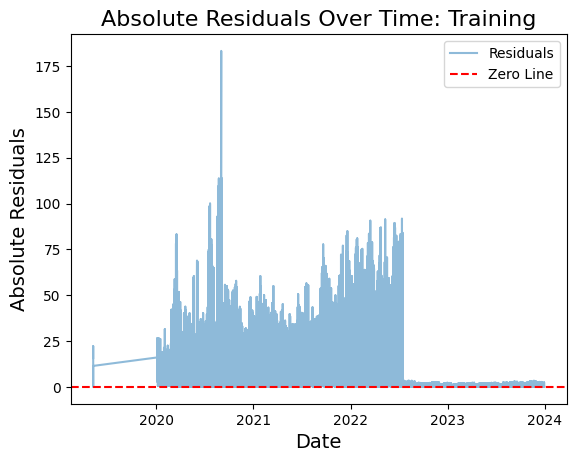

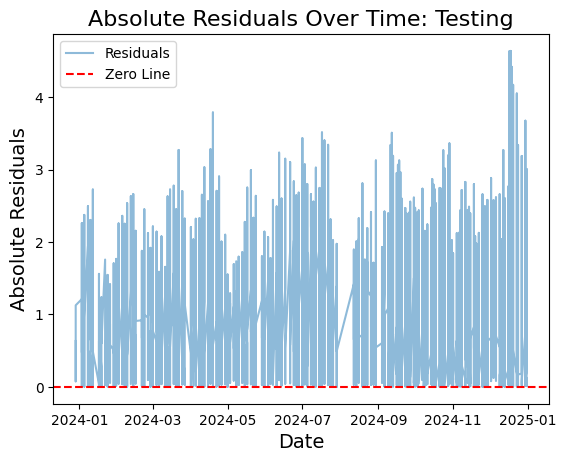

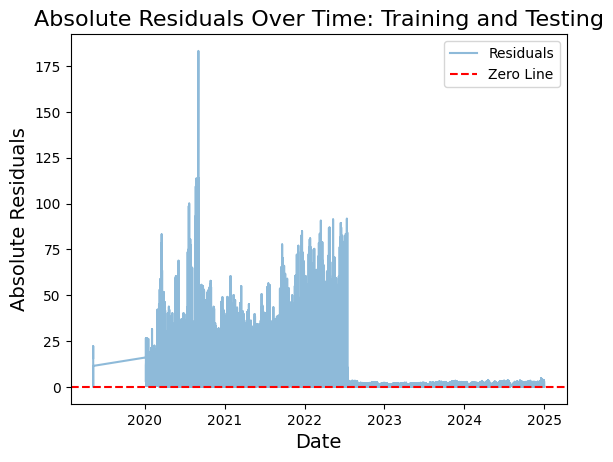

In [33]:
# plotting absolute residuals over time
# train
_ = plt.plot(
    X_train.index,
    np.abs(res_train),
    label="Residuals",
    alpha=0.5
)
_ = plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
_ = plt.xlabel("Date", fontsize=14)
_ = plt.ylabel("Absolute Residuals", fontsize=14)
_ = plt.title("Absolute Residuals Over Time: Training", fontsize=16)
_ = plt.legend()
plt.show()

# test
_ = plt.plot(
    X_test.index,
    np.abs(res_test),
    label="Residuals",
    alpha=0.5
)
_ = plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
_ = plt.xlabel("Date", fontsize=14)
_ = plt.ylabel("Absolute Residuals", fontsize=14)
_ = plt.title("Absolute Residuals Over Time: Testing", fontsize=16)
_ = plt.legend()
plt.show()

# combined
_ = plt.plot(
    np.concatenate([X_train.index, X_test.index]),
    np.concatenate([np.abs(res_train), np.abs(res_test)]),
    label="Residuals",
    alpha=0.5
)
_ = plt.axhline(y=0, color='r', linestyle='--', label="Zero Line")
_ = plt.xlabel("Date", fontsize=14)
_ = plt.ylabel("Absolute Residuals", fontsize=14)
_ = plt.title("Absolute Residuals Over Time: Training and Testing", fontsize=16)
_ = plt.legend()
plt.show()